# **LABEL PROPAGATION NOTEBOOK**

# Bibliothèques

In [1]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

# Functions

In [2]:
##############################################
# Fonctions liées à l'extraction des données
##############################################

def filtrer(src, dst, date):
    date=[date]
    for line in src:
        if 'mentions.CSV' not in line:
            continue
        arr = line.split(' ')
        for time in date:
            if time in arr[2]:
                dst.write(arr[0]+' '+arr[1]+' '+arr[2])
                
def dezip(filezip, pathdst = ''): 
    if pathdst == '': pathdst = os.getcwd()  ## on dezippe dans le repertoire locale 
    zfile = zipfile.ZipFile(filezip, 'r') 
    for i in zfile.namelist():  ## On parcourt l'ensemble des fichiers de l'archive 
        #print (i) 
        if os.path.isdir(i):   ## S'il s'agit d'un repertoire, on se contente de creer le dossier 
            try: os.makedirs(pathdst + os.sep + i) 
            except: pass 
        else: 
            try: os.makedirs(pathdst + os.sep + os.path.dirname(i)) 
            except: pass 
            data = zfile.read(i)                   ## lecture du fichier compresse 
            fp = open(pathdst + os.sep + i, "wb")  ## creation en local du nouveau fichier 
            fp.write(data)                         ## ajout des donnees du fichier compresse dans le fichier local 
            fp.close() 
    zfile.close() 

    
def open_data(fichier):
    #data=pd.read_csv(fichier,sep="\t",header=None)
    #column_names=['GlobalEventID','EventTimeDate','MentionTimeDate','MentionType','MentionSourceName','MentionIdentifier','SentenceID','Actor1CharOffset','Actor2CharOffset','ActionCharOffset','InRawText','Confidence','MentionDocLen','MentionDocTone','MentionDocTranslationInfo','Extras']
    #data.columns=column_names
    data = pd.read_csv(fichier,sep = '\t',decimal = '.',index_col=0)
    return data


In [3]:
def creation_fichier_csv(date):

    # Création du fichier contenant uniquement les liens des fichier mentions qui nous interressent
    source = open("masterfilelist.txt", "r") # Ouverture du fichier source
    destination = open("data_list.csv", "w") # Ouverture du fichier destination
    filtrer(source, destination, date) # Filtrage
    destination.close()# Fermeture du fichier destination
    source.close()# Fermerture du fichier source

    #enregistrement fichier csv
    master_data = pd.read_csv('data_list.csv',sep= ' ',header = None,engine='python')
    master_data.columns = ['1','2','url']

    #suppression lignes inutiles
    for index, row in master_data.iterrows():
        if '.mentions.CSV' not in row['url']:
            master_data = master_data.drop(index)

    # vide le dossier où stocker les donnees
    for element in os.listdir("C:/Users/maell/Fake_News_Project/data_folder"):
        path="C:/Users/maell/Fake_News_Project/data_folder/"+element
        os.remove(path)

    #telecharge et dezippe les fichiers depuis le web
    for index, row in master_data.iterrows():
        element = row['url']
        urllib.request.urlretrieve(element,'file')
        dezip('file', 'data_folder')

    # Création du DataFrame Complet
    column_names=['GlobalEventID','EventTimeDate','MentionTimeDate','MentionType','MentionSourceName','MentionIdentifier','SentenceID','Actor1CharOffset','Actor2CharOffset','ActionCharOffset','InRawText','Confidence','MentionDocLen','MentionDocTone','MentionDocTranslationInfo','Extras']
    all_data=pd.DataFrame({'GlobalEventID':[],'EventTimeDate':[],'MentionTimeDate':[],'MentionType':[],'MentionSourceName':[],'MentionIdentifier':[],'SentenceID':[],'Actor1CharOffset':[],'Actor2CharOffset':[],'ActionCharOffset':[],'InRawText':[],'Confidence':[],'MentionDocLen':[],'MentionDocTone':[],'MentionDocTranslationInfo':[],'Extras':[]},columns = column_names, index=[])

    for fichier in os.listdir("C:/Users/maell/Fake_News_Project/data_folder"):
        path_fichier="C:/Users/maell/Fake_News_Project/data_folder/"+fichier
        new_data=open_data(path_fichier)
        all_data = pd.concat([all_data,new_data],ignore_index = True)

    # Sauvegarde du fichier all_data.csv
    nom_fichier='all_data_'+date+'.csv'
    all_data.to_csv(nom_fichier, sep='\t', decimal= '.')
    print(nom_fichier+' enregistré')


In [ ]:
#####################
# Création de graphs
#####################

#Création d'un graph binaire 
def graph_sources(data):
    fichier='all_data_'+date+'.csv'
    data=open_data(fichier)
    
    G=nx.Graph()
    
    for source in data.MentionSourceName.unique():
        # add is nan
        G.add_node(source)
    for event in data.GlobalEventID.unique():
        list_source=data[data.GlobalEventID==event].MentionSourceName
        for source1 in list_source:
            for source2 in list_source:
                if source1!=source2:
                    G.add_edge(source1,source2)
    return G

#Création d'un graph avec comme poids le nombre d'évenements partagés
def graph_sources_poids(data):
    fichier='all_data_'+date+'.csv'
    print(fichier)
    data=open_data(fichier)
    
    G=nx.Graph()
    
    for source in data.MentionSourceName.unique():
        G.add_node(source)
    for event in data.GlobalEventID.unique():
        liste_source=data[data.GlobalEventID==event].MentionSourceName
        for comb in combinations(liste_source,2):
            if comb[0]!=comb[1]:
                if G.has_edge(comb[0],comb[1]):
                    G[comb[0]][comb[1]]['weight'] += 1
                else:
                    G.add_edge(comb[0], comb[1], weight=1)
    return G
                    
def cleaning_graph(H):
    G=nx.Graph.copy(H)
    
    # Suppression des nan
    list_source=list(G.nodes)
    for source in list_source:
        if type(source) is not str:
            G.remove_node(source)
    
    # Remove edges not weigted enough
    edges_to_remove = []
    for edge in G.edges():
        if G[edge[0]][edge[1]]['weight']<5:
            edges_to_remove.append(edge)
    if(edges_to_remove!=[]):
        G.remove_edges_from(edges_to_remove)

    # Suppression des éléments non connectés
    composants=list(nx.connected_components(G))
    i=0;
    while i<len(composants):
        if len(composants[i])==1:
            composant_supp=list(composants[i])[0]
            G.remove_node(composant_supp)
        i=i+1
        
    
    return G
        
def classification_géographique_url(graph):
    for source in graph.nodes():
        if source.endswith(".au"):
            graph.node[source]['URL']='Australia'
            graph.node[source]['Country']='Australia'
        elif source.endswith(".uk"):
            graph.node[source]['URL']='UK'
            graph.node[source]['Country']='UK'
        elif source.endswith(".in"):
            graph.node[source]['URL']='India'
            graph.node[source]['Country']='India'
        elif source.endswith(".nz"):
            graph.node[source]['URL']='New Zealand'
            graph.node[source]['Country']='New Zealand'
        elif source.endswith(".org"):
            graph.node[source]['URL']='Organization'
            graph.node[source]['Country']='Organization'
        elif source.endswith(".us"):
            graph.node[source]['URL']='USA'
            graph.node[source]['Country']='USA'
        elif source.endswith(".international"):
            graph.node[source]['URL']='International'
            graph.node[source]['Country']='International'
        elif source.endswith(".zm"):
            graph.node[source]['URL']='Zambia'
            graph.node[source]['Country']='Zambia'
        elif source.endswith(".ca"):
            graph.node[source]['URL']='Canada'
            graph.node[source]['Country']='Canada'
        elif source.endswith(".za"):
            graph.node[source]['URL']='South Africa'
            graph.node[source]['Country']='South Africa'
        else:
            graph.node[source]['URL']='Not Classified'
            

def dataframe_url(graph):
    dataframe=pd.DataFrame({'WebsiteURL':[], 'URL':[]},columns = ['WebsiteURL','URL'],index=[])
    for source in graph.nodes():
        if source.endswith(".au"):
            url='Australia'
        elif source.endswith(".uk"):
             url='UK'
        elif source.endswith(".in"):
             url='India'
        elif source.endswith(".nz"):
             url='New Zealand'
        elif source.endswith(".org"):
             url='Organization'
        elif source.endswith(".us"):
             url='USA'
        elif source.endswith(".international"):
             url='International'
        elif source.endswith(".zm"):
             url='Zambia'
        elif source.endswith(".ca"):
             url='Canada'
        elif source.endswith(".za"):
             url='South Africa'
        else:
            url='Not Classified'
        dataframe = dataframe.append([{'WebsiteURL':source,'URL':url}], ignore_index=True)
    return dataframe

def classification_géographique_csv(graph):
    countries = pd.read_csv('source_country.csv',sep = ';',decimal = '.')
    for source in graph.nodes():
        if source in countries.WebsiteURL.values :
            liste_pays=countries[countries.WebsiteURL==source]
            pays=liste_pays['Country'].value_counts().index[0]
            graph.node[source]['pays']=pays
            
def create_country_reference(G):
    #Récupération des dataframes de référence
    countries = pd.read_csv('source_country.csv',sep = ';',decimal = '.')
    url = dataframe_url(G)
    
    #Création d'un dataframe de référence unique
    countries=countries[['WebsiteURL','Country']]
    countries.set_index('WebsiteURL',inplace=True)
    url.set_index('WebsiteURL',inplace=True)

    reference= url.join(countries)
    reference= reference[~reference.index.duplicated(keep='first')] #On supprime les lignes multiples
    reference= reference.fillna(value='Not Classified') #On remplace NaN par 'Not Classified'

    #Mise à zéro du nombre de différences
    diff_url_csv=0

    # Mise en forme du dataframe de reference
    for index,row in reference.iterrows():
        ligne=reference.loc[index]
        if ligne.Country=='Not Classified':
            ligne.Country=ligne.URL
        if ligne.Country!='Not Classified'  and ligne.URL!=ligne.Country:
            diff_url_csv+=1
        
    #supprier la colone url
    reference.drop('URL',1)

    #Print
    print('Nombre de sites ayant un pays issus de l\'URL différent de celui issu du CSV :',diff_url_csv)
    
    return reference

In [ ]:
def label_propagation_pays(G,nodes_liste,reference):
    # Label propagation du label 'label' via le dataframe reference sur le graph 'G', pour les nodes de la liste nodes_liste
    
    compteur=0
    compteur_retry=0
    #Tant que l'on a pas traité tous les points ...
    while nodes_liste!=[]:
        
        #On tire un point au hasard
        number_nodes=len(nodes_liste)
        if number_nodes>1:
            webURL=nodes_liste[random.randint(0,number_nodes-1)];
        else:
            webURL=nodes_liste[0]
        node = G.nodes[webURL]
        
        #On récupère les attributs
        country=reference.loc[webURL].Country
        
        #SI PAS DEJA UN PAYS :
        if country=='Not Classified' : #Si pas classifié
    
            #On récupère tout les voisins, et on leur attribue leur pays 
            voisins=dict(G[webURL])
            data_voisins = pd.DataFrame.from_dict(voisins, orient='index')
            truc=data_voisins.join(reference)
            truc = truc.replace('Not Classified',np.nan)
        
            #On calcul le poids de chaque voisin
            tab=truc[['weight','Country']].groupby(['Country']).agg(['count'])

            #On récupère celui qui a le plus de poids
            weightCount_sort=tab.sort_values([('weight','count')],ascending=False)
            try:
                weightChoosenCountry=weightCount_sort.iloc[0][('weight','count')]
            except: #Si on a aucun pays en voisin
                weightChoosenCountry=-1
                
            #On calcul le poids total
            serie=pd.Series(truc.weight.values, index=truc.Country)
            sum_weight=serie.sum()
        
            #On vérifie que le poids relatif du pays choisi est assez important (min 0% ici)
            if (weightChoosenCountry/sum_weight)>0:
                #Si oui, on lui attribut son pays et on le retire de la liste à traiter
                ChoosenCountry=weightCount_sort.iloc[0].name
                node['Country']=ChoosenCountry #On attribut le node
                reference.loc[webURL].Country=ChoosenCountry #On attribut dans reference
                nodes_liste.remove(webURL)
                compteur=compteur+1
                print('Classified :',compteur)
                compteur_retry=0
            else:
                compteur_retry+=1
                print('Retry',compteur_retry)
                if compteur_retry>100:
                    return
        # SI DEJA UN PAYS : on le retire de la liste
        else:
            nodes_liste.remove(webURL)

# Computation of various CSV files and Graphs

In [ ]:
list_date=['20180331']#,'20180330','20180430','20180530','20180630'] 
    #'20170830','20170930','20171030','20171130','20171230','20180130','20180230','20180330','20180430','20180530'
           #,'20180630'] #07 08 09 a rajouter après

for date in list_date:
    creation_fichier_csv(date)


C:\Users\maell\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [ ]:
# Création des graphs
list_date=[]
    #'20170830','20170930','20171030','20171130','20171230','20180130','20180230','20180330','20180430','20180530'
           #,'20180630','20180730','20180830','20180930']

for date in list_date:
    all_data='all_data_'+date+'.csv'
    G=graph_sources_poids(all_data)
    print('Ready to clean')
    G_clean=cleaning_graph(G);
    classification_géographique_url(G_clean)
    nom_graph='graph_'+date+'.gexf'
    nx.write_gexf(G_clean,nom_graph)
    print(date+' : Graph Created')

# Label Propagation on several days

In [ ]:
list_days= ['20170830','20170930','20171030','20171130','20171230','20180130','20180227','20180330','20180412',
            '20180430','20180530','20180630','20180730','20180830','20180930']

study_classification=pd.DataFrame()

for day in list_days:
    file='graph_'+day+'.gexf'
    G=nx.read_gexf(file)
    
    #reference
    reference=create_country_reference(G)
    print('Reference Created')
    
    #Label Propagation
    sources=[x for x,y in G.nodes(data=True) if y['URL']=='Not Classified']
    label_propagation_pays(G,sources,reference)
    print('Label Propagation OK')
    
    #Injection in study_classification DataFrame
    dict_nodes=dict(G.nodes(data=True))
    study_this_day=pd.DataFrame.from_dict(dict_nodes,orient='index')
    study_this_day=study_this_day[['Country']]
    study_this_day = study_this_day.rename(columns={'Country': day})

    
    #Merge with study_classification
    study_classification=pd.merge(study_classification, study_this_day,how='outer', right_index=True, left_index=True)

    print('OK '+file)

In [ ]:
study_classification.to_csv('study_classification.csv', sep='\t', decimal= '.')

In [4]:
study_classification = pd.read_csv('study_classification.csv',sep = '\t',decimal = '.',index_col=0)

In [5]:
list_c_country=[]
list_c_number=[]
list_confidence=[]
for index,row in study_classification.iterrows():
    ligne=study_classification.loc[index]
    columns=study_classification.columns
    liste=[]
    for i in range (len(study_classification.columns)):
        liste.append(ligne[i])
    c = Counter(liste)
    nb_nan=c[nan]
    if pd.isnull(c.most_common(1)[0][0]):                
        if c.most_common(1)[0][1]==len(study_classification.columns):
            list_c_country.append('Not Classified')
            list_c_number.append(0)
            list_confidence.append(0)
        else:
            list_c_country.append(c.most_common(2)[1][0])
            list_c_number.append(c.most_common(2)[1][1])
            list_confidence.append(c.most_common(2)[1][1]/(len(study_classification.columns)-nb_nan))
    else:
        list_c_country.append(c.most_common(1)[0][0])
        list_c_number.append(c.most_common(1)[0][1])
        list_confidence.append(c.most_common(1)[0][1]/(len(study_classification.columns)-nb_nan))
        
study_classification['Most appearance country'] =list_c_country
study_classification['Nb of appearance'] =list_c_number
study_classification['Confidence'] =list_confidence

In [6]:
study_classification.head()

,20170830,20170930,20171030,20171130,20171230,20180130,20180227,20180330,20180412,20180430,20180530,20180630,20180730,20180830,20180930,Most appearance country,Nb of appearance,Confidence
1005freshradio.ca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,Canada,8,1.000000
1009theeagle.com,Organization,UK,USA,Australia,India,USA,USA,Organization,USA,UK,UK,NaN,NaN,NaN,NaN,USA,4,0.363636
100milefreepress.net,Canada,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Canada,NaN,NaN,Canada,2,1.000000
1011now.com,USA,UK,UK,UK,UK,USA,USA,UK,USA,UK,UK,UK,UK,UK,UK,UK,11,0.733333
1013online.com,USA,USA,UK,USA,USA,Organization,NaN,USA,USA,USA,UK,USA,UK,NaN,NaN,USA,8,0.666667


In [7]:
print('Nombre moyen d\'apparition : ',mean(study_classification['Nb of appearance']))
print('Confiance moyenne : ',mean(study_classification['Confidence']))

Nombre moyen d'apparition :  3.715181843811672
Confiance moyenne :  0.7441197859403469


# Verification with GDELT Master File

In [2]:
master = pd.read_csv('MASTER-GDELTDOMAINSBYCOUNTRY-MAY2018.TXT', delimiter="\t", names=['WebsiteURL','CountryCode','Country'])
master=master.set_index('WebsiteURL')
master.head()

,CountryCode,Country
WebsiteURL,,
0-100.it,IT,Italy
0-50.ru,RS,Russia
0-60mag.com,US,United States
0-debt.com,US,United States
000fff.org,US,United States


In [8]:
verification = study_classification[['Most appearance country']]
verification = verification.rename({'Most appearance country':'Found country'}, axis='columns')
verification = verification.join(master[['Country']], how='inner')

# modification pour USA et UK
verification['Country'].replace(to_replace=['United States'],value='USA',inplace=True)
verification['Country'].replace(to_replace=['United Kingdom'],value='UK',inplace=True)

verification

,Found country,Country
1005freshradio.ca,Canada,Canada
1009theeagle.com,USA,USA
100milefreepress.net,Canada,Canada
1011now.com,UK,USA
1013online.com,USA,USA
1015hankfm.com,USA,USA
1015thehawk.com,UK,Canada
1017chuckfm.com,USA,USA
1017hotfm.com,USA,USA
1019online.com,UK,USA


In [28]:
print('Number of well classified :',len(verification[verification['Found country']==verification['Country']]))
print('Number of bad classified :',len(verification[verification['Found country']!=verification['Country']]))
print('----------------------------')
found_countries=verification['Found country'].unique()
countries=verification['Country'].unique()
print('Nb of found countries :',len(found_countries))
print('Nb of real countries :',len(countries))
print('----------------------------')
print('Just for the 11 countries we know :')

verification_on_11=verification[verification['Country'].isin(found_countries)] #We keep only "our" countries
verification_on_11=verification_on_11[verification_on_11['Found country'].isin(verification_on_11['Country'].unique())]#on enlève international, not classified ect
print('Number of well classified :',len(verification_on_11[verification_on_11['Found country']==verification_on_11['Country']]))
print('Number of bad classified :',len(verification_on_11[verification_on_11['Found country']!=verification_on_11['Country']]))

# juste sur les 11 pays + matrix confusion

Number of well classified : 4915
Number of bad classified : 8851
----------------------------
Nb of found countries : 11
Nb of real countries : 178
----------------------------
Just for the 11 countries we know :
Number of well classified : 4915
Number of bad classified : 5209


In [42]:
y_actual = verification_on_11['Country']
y_predicted = verification_on_11['Found country']

In [43]:
df_confusion = pd.crosstab(y_actual, y_predicted)

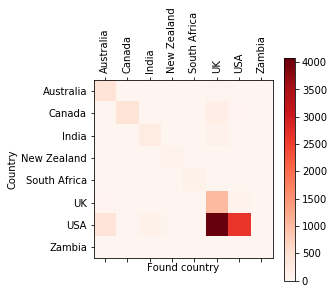

In [50]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=90)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

Lot of true positive for USA
But lot of errors for UK and USA -> probably because UK and USA very connected (same subjects) and a lot lot more references for USA than UK

AND
Lot of countries are not in our data base ...

# Label Propagation : Cross Validation

In [ ]:
#choosing the day

list_days=['20170830','20170930','20171030','20171130','20171230']

In [ ]:
#Chossing the file to do cross validation on

for day in list_days:

    file='graph_'+day+'.gexf'
    G=nx.read_gexf(file)

    # Test and Training set selection
    total_set=[x for x,y in G.nodes(data=True) if y['URL']!='Not Classified'] #we take every node which is labelized
    train_set=[]
    test_set=[]

    reference_total_set=create_country_reference(G)
    reference_train_set=pd.DataFrame.copy(reference_total_set)

    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            reference_train_set.drop([total_set[i]]) # TO BE CHECK
        else: #Ratio used : train_set=2/3 ; test_set=1/3
            train_set.append(total_set[i])


    # Label propagation
    test_set_bis=list.copy(test_set)
    label_propagation_pays(G,test_set_bis,reference_train_set)

    # Label propagation evaluation
    bad_classified_nodes=[]
    well_classified_nodes=[]
    for test_node in test_set:
        ref=reference_total_set.loc[test_node].Country
        if G.nodes[test_node]['Country']!=ref:
            bad_classified_nodes.append(test_node)
        else:
            well_classified_nodes.append(test_node)

    print(day)
    print('Nb of bad classified nodes : ',len(bad_classified_nodes))
    print('% of bad classified nodes : ', len(bad_classified_nodes)/len(test_set)) 
    print('Nb of well classified nodes : ',len(well_classified_nodes))
    print('% of well classified nodes : ', len(well_classified_nodes)/len(test_set)) 
    print('--------------------------------------------------------')

# Conclusion
**Always less than 2% error on label propagation.**
Be carfull : in the real graph, it could be more error, because on our test the nodes may be more connected to "sur" sources than in the real complete graph.